In [26]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [27]:
import torch
torch.cuda.is_available()

True

In [28]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [29]:
import os
import shutil
import random

# Paths
input_base = '/kaggle/input/plant-disease-detection/Dataset'
working_base = '/kaggle/working/datasets_folder'
categories = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']  # match the actual folder names exactly
train_ratio = 0.8

# Step 1: Copy original data to writable working directory
for category in categories:
    src_dir = os.path.join(input_base, category)
    dst_dir = os.path.join(working_base, category)
    os.makedirs(dst_dir, exist_ok=True)

    for filename in os.listdir(src_dir):
        src_file = os.path.join(src_dir, filename)
        dst_file = os.path.join(dst_dir, filename)
        try:
            if os.path.getsize(src_file) > 0:
                shutil.copy2(src_file, dst_file)
        except:
            continue  # skip corrupt or unreadable files

# Step 2: Create train/test folders in working directory
for split in ['train', 'test']:
    for category in categories:
        os.makedirs(os.path.join(working_base, split, category), exist_ok=True)

# Step 3: Split and copy files
for category in categories:
    src_dir = os.path.join(working_base, category)
    all_files = [f for f in os.listdir(src_dir) if os.path.getsize(os.path.join(src_dir, f)) > 0]
    random.shuffle(all_files)

    split_idx = int(len(all_files) * train_ratio)
    train_files = all_files[:split_idx]
    test_files = all_files[split_idx:]

    for f in train_files:
        shutil.copy2(os.path.join(src_dir, f), os.path.join(working_base, 'train', category, f))
    for f in test_files:
        shutil.copy2(os.path.join(src_dir, f), os.path.join(working_base, 'test', category, f))

print("Data split complete. Check /kaggle/working/datasets_folder/")


Data split complete. Check /kaggle/working/datasets_folder/


In [30]:
import os
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset

class ImageDatasets(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_paths = []
        self.img_labels = []
        self.class_name = {}
        self.transform = transform

        valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')  # Acceptable formats

        for label, class_dir in enumerate(os.listdir(img_dir)):
            class_path = os.path.join(img_dir, class_dir)
            if not os.path.isdir(class_path):
                continue  # Skip non-folder files in the top directory
            self.class_name[label] = class_dir

            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(valid_exts):
                    self.img_paths.append(os.path.join(class_path, img_name))
                    self.img_labels.append(label)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
        except UnidentifiedImageError:
            print(f"[Warning] Skipping file: {img_path}")
            # Return the next valid image (wrap around if at the end)
            return self.__getitem__((idx + 1) % len(self.img_paths))

        if self.transform:
            image = self.transform(image)

        return image, label


In [31]:
# as you know the dataset is containing the image which are in different different resolution so to make it in same resolution i.e size we use transpose.

transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
    )


In [32]:
train_dir="/kaggle/working/datasets_folder/train"
test_dir="/kaggle/working/datasets_folder/test"

train_image_dataset = ImageDatasets(img_dir=train_dir, transform=transform)
test_image_dataset= ImageDatasets(img_dir=test_dir, transform=transform)

In [33]:
# Dataloading
train_data_loder=DataLoader(dataset=train_image_dataset, batch_size=32, shuffle=True)
test_data_loder=DataLoader(dataset=test_image_dataset, batch_size=32, shuffle=True)

In [34]:
import matplotlib.pyplot as plt
import numpy as np

In [35]:
print(train_image_dataset.class_name)
print(test_image_dataset.class_name)

{0: 'Apple___Cedar_apple_rust', 1: 'Pepper__bell___Bacterial_spot', 2: 'Apple___healthy', 3: 'Potato___Early_blight', 4: 'Apple___Apple_scab', 5: 'Potato___healthy', 6: 'Tomato__Tomato_mosaic_virus', 7: 'Potato___Late_blight', 8: 'Tomato_Septoria_leaf_spot', 9: 'Tomato__Tomato_YellowLeaf__Curl_Virus', 10: 'Tomato_Bacterial_spot', 11: 'Tomato_Early_blight', 12: 'Tomato_Late_blight', 13: 'Tomato_Leaf_Mold', 14: 'Tomato_healthy', 15: 'Tomato__Target_Spot', 16: 'Pepper__bell___healthy', 17: 'Tomato_Spider_mites_Two_spotted_spider_mite', 18: 'Corn_(maize)___Northern_Leaf_Blight', 19: 'Corn_(maize)___healthy', 20: 'Corn_(maize)___Common_rust_', 21: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 22: 'Apple___Black_rot'}
{0: 'Apple___Cedar_apple_rust', 1: 'Pepper__bell___Bacterial_spot', 2: 'Apple___healthy', 3: 'Potato___Early_blight', 4: 'Apple___Apple_scab', 5: 'Potato___healthy', 6: 'Tomato__Tomato_mosaic_virus', 7: 'Potato___Late_blight', 8: 'Tomato_Septoria_leaf_spot', 9: 'Tomato_

torch.Size([32, 3, 128, 128]) torch.Size([32])
(3, 128, 128)
Tomato_healthy
(128, 128, 3)
14


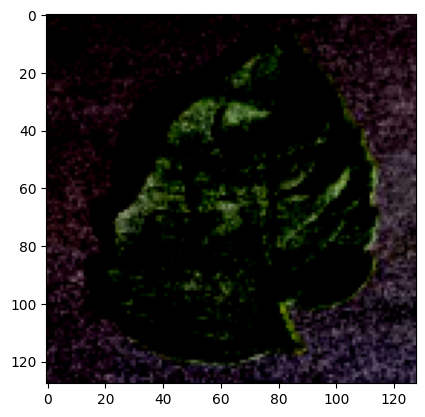

In [36]:
for image, labels in train_data_loder:
    print(image.shape, labels.shape)
    img = image[0].numpy()
    print(img.shape)
    labels=labels[0].item()
    print(train_image_dataset.class_name[labels])
    img=np.transpose(img, (1,2,0))
    print(img.shape)
    print(labels)
    plt.imshow(img)
    break

In [37]:
# CUstom CNN Archetecture
import torch.nn as nn
import torch.optim as optim

class CustomeCnnModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomeCnnModel, self).__init__()
        self.input_dim=input_dim
        self.num_classes=num_classes

        self.Conv_layers=nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self._to_linear = None
        self._get_conv_output(self.input_dim)

        self.fc_layers=nn.Sequential(
            nn.Linear(self._to_linear, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_classes),
        )

    def _get_conv_output(self, input_dim=128):
        with torch.no_grad():
            dummy_input=torch.zeros(1, 3, input_dim, input_dim)
            output=self.Conv_layers(dummy_input)
            self._to_linear = output.view(1, -1).size(1)

    def forward(self, x):
        x = self.Conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x
        
    

In [38]:
# initialize the model with gpus
devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(devices)

cuda


In [39]:
model = CustomeCnnModel(input_dim=128, num_classes=23).to(devices)
print(model)

CustomeCnnModel(
  (Conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [40]:
criterian = nn.CrossEntropyLoss()
optimizers = optim.Adam(model.parameters(), lr=0.001)

In [41]:
# Training loop
epochs = 2
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_data_loder:
        images, labels = images.to(devices), labels.to(devices)
        optimizers.zero_grad()
        outputs = model(images)

        loss = criterian(outputs, labels)
        loss.backward()
        optimizers.step()
        running_loss += loss.item()
    print(f"Epochs : {epoch + 1}/{epochs}, loss : {running_loss / len(train_data_loder)}")

Epochs : 1/2, loss : 0.7899251572099053
Epochs : 2/2, loss : 0.3197595354284392


In [42]:
for images, labels in test_data_loder:
  print(labels.shape)
  break

torch.Size([32])


In [45]:
# Evaluate model

model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_data_loder:
    images,labels = images.to(devices), labels.to(devices)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test accuracy is :{100* correct / total:.2f}%")


Test accuracy is :94.26%


In [46]:
torch.save(model.state_dict(), "cnn_model.pth")

In [47]:
import cv2

In [50]:
class ImageClassifier:
  def __init__(self, model_path, class_names):
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model = CustomeCnnModel(input_dim=128, num_classes=23).to(self.device)
    self.model.load_state_dict(torch.load(model_path, map_location=self.device))
    self.model.eval()
    self.class_names = class_names
    self.transform = transforms.Compose([
      transforms.Resize((128,128)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
    )

  def predict(self, image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = self.transform(image).unsqueeze(0).to(self.device)
    with torch.no_grad():
      output = self.model(input_tensor)
      _, predicted = torch.max(output, 1)
    label = self.class_names[predicted.item()]

    img = cv2.imread(image_path)
    cv2.putText(img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.imwrite("output_image.jpg",img)
    return label



In [51]:
classfier = ImageClassifier("/kaggle/working/cnn_model.pth", train_image_dataset.class_name )
label = classfier.predict("/kaggle/input/plant-disease-detection/Dataset/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG")
print(f"Predicted class is : {label}")

Predicted class is : Apple___Apple_scab
